# Preparing data

- Warning
This program is quite memory-heavy. It runs OK with 128 GB RAM, but may crash with less RAM. Consider using a subset of data to save memory. E.g., setting augmentFlag = False in the second code block can save a significant amount of RAM.

# Number of recombination data points from simulations:  7931
# Dimention of local density field:  (7931, 33, 33, 33)


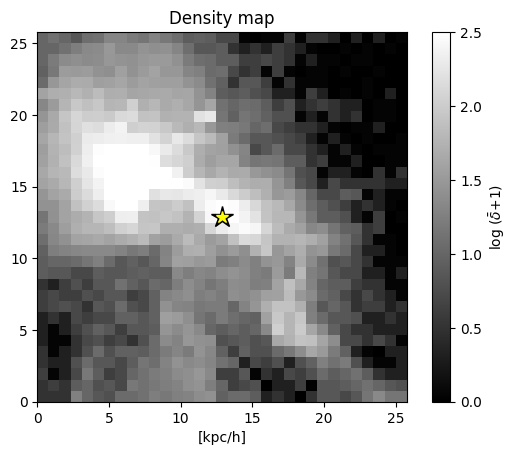

In [1]:
import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

cell = 200/256 # size of pixel in the density map in comoving kpc/h

hf = h5.File('./simData.h5', 'r')
# print(hf.keys()) #['AccRec', 'InitDen', 'LocDen']
# Converting quantities into log scale to reduce the dynamic range
logAccRec0  = np.log10(hf['AccRec'][:]) # The accumulated recombination for 7931 gas particles in a photo-evaporation simulation. We want to predict this quantity without running simulations.
logLocDen0  = np.log10(hf['LocDen'][:,:,:,:]+0.1); # 33 by 33 by 33 density field around each of the 7931 gas particles. We will use this information to 'predict' the recombination rate.
logInitDen0 = np.log10(hf['InitDen'][:]+1e-6); # density of the individual gas particles. We will use this information, too, for the prediction. The accuracy is increased when we use this as a secondary input.


Ntot0=np.shape(logAccRec0)[0]; Ntot = Ntot0
print('# Number of recombination data points from simulations: ',Ntot)

print('# Dimention of local density field: ', logLocDen0.shape)
ndim = logLocDen0.shape[1]; Lbox = cell*ndim; 
# print(LocDen[0,:,:,0].shape)
fig, ax = plt.subplots(1,1)
def plotLocDenSlice(logLocDenSlice, ax, fig, cb=False, title='Density map'):
    im = ax.imshow(logLocDenSlice.T,origin='lower',vmin=0,vmax=2.5,cmap='gray',extent=[0,Lbox,0,Lbox]); 
    ax.plot(Lbox/2,Lbox/2,'*',markersize=16,color='k');ax.plot(Lbox/2,Lbox/2,'*',markersize=9,color=(1,1,0,1))
    ax.set_xlabel('[kpc/h]'); ax.set_title(title)
    if cb:
        cb = fig.colorbar(im,ax=ax); cb.set_label(r'log ($\bar\delta$+1)')
    
plotLocDenSlice(logLocDen0[0,:,:,ndim//2], ax, fig, True); plt.show()


# Example of flipped density maps


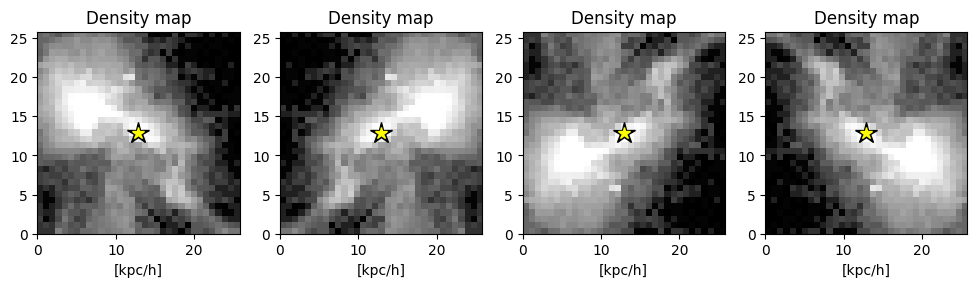

# Shuffling the data ... 
# Done.


In [3]:
# The physics behind recombination should be rotationally invariant. 
# We will produce 7 copies for each case by flipping the 3D field along x,y and z direction while keeping the recombination same and augment it to the original data.
logAccRec, logLocDen, logInitDen = logAccRec0, logLocDen0, logInitDen0
augmentFlag = True 
if augmentFlag:
    Ntot = Ntot0*8
    logAccRec = np.zeros(Ntot)
    logLocDen = np.zeros([Ntot,ndim,ndim,ndim])
    logInitDen = np.zeros(Ntot)
    
    logLocDen[0:Ntot0,        :,:,:] = logLocDen0[:,:,:,:]
    logLocDen[Ntot0:2*Ntot0,  :,:,:] = logLocDen0[:,:,:,::-1]
    logLocDen[2*Ntot0:3*Ntot0,:,:,:] = logLocDen0[:,:,::-1,:]
    logLocDen[3*Ntot0:4*Ntot0,:,:,:] = logLocDen0[:,:,::-1,::-1]
    logLocDen[4*Ntot0:5*Ntot0,:,:,:] = logLocDen0[:,::-1,:,:]
    logLocDen[5*Ntot0:6*Ntot0,:,:,:] = logLocDen0[:,::-1,:,::-1]
    logLocDen[6*Ntot0:7*Ntot0,:,:,:] = logLocDen0[:,::-1,::-1,:]
    logLocDen[7*Ntot0:8*Ntot0,:,:,:] = logLocDen0[:,::-1,::-1,::-1]
    for i in range(8):
        logAccRec [i*Ntot0:(i+1)*Ntot0] = logAccRec0
        logInitDen[i*Ntot0:(i+1)*Ntot0] = logInitDen0
    print('# Example of flipped density maps')
    fig, axes = plt.subplots(1,4,figsize=(12,3))
    plotLocDenSlice(logLocDen[0,      :,:,ndim//2], axes[0], fig, False)
    plotLocDenSlice(logLocDen[4*Ntot0,:,:,ndim//2], axes[1], fig, False)
    plotLocDenSlice(logLocDen[2*Ntot0,:,:,ndim//2], axes[2], fig, False)
    plotLocDenSlice(logLocDen[6*Ntot0,:,:,ndim//2], axes[3], fig, False)
    plt.show()
    
print('# Shuffling the data ... ')
iRand = np.arange(Ntot); np.random.seed(0); np.random.shuffle(iRand)
# print(iRand[:100])
logAccRec  = logAccRec[iRand]
logLocDen  = logLocDen[iRand]
logInitDen = logInitDen[iRand]
print('# Done.')

# Plotting local density. This takes some time. Please wait.


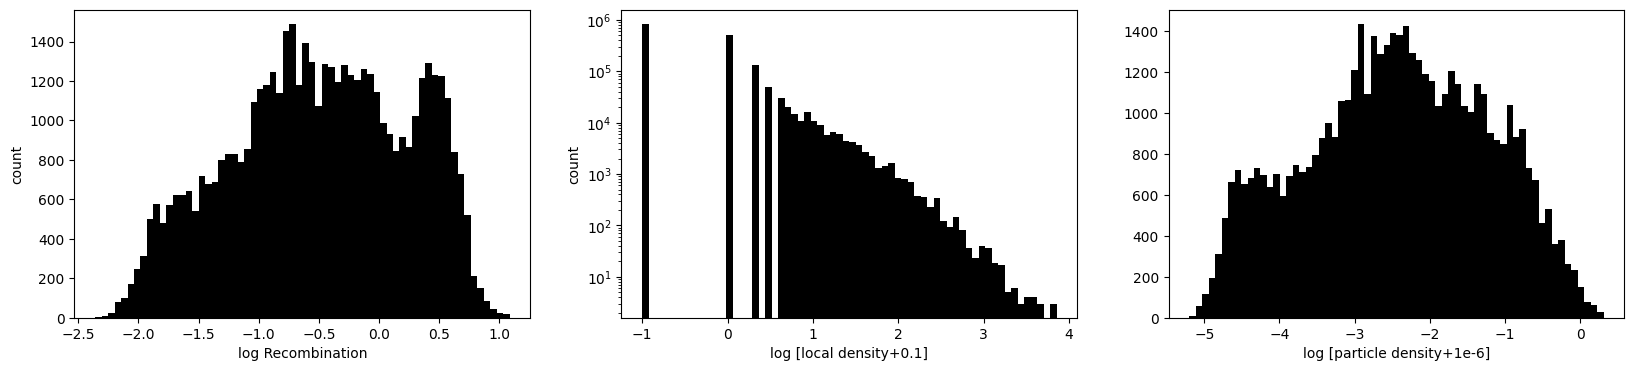

In [4]:
# Splitting data in the training, validation, test sets

N_val, N_test = int(0.1*Ntot), int(0.1*Ntot)
N_train = Ntot - N_val - N_test

X_train, X2_train, y_train = logLocDen[:N_train,:,:,:],              logInitDen[:N_train],              logAccRec[:N_train]
X_val,   X2_val,   y_val   = logLocDen[N_train:N_train+N_val,:,:,:], logInitDen[N_train:N_train+N_val], logAccRec[N_train:N_train+N_val]
X_test,  X2_test,  y_test  = logLocDen[N_train+N_val:,:,:,:],        logInitDen[N_train+N_val:],        logAccRec[N_train+N_val:]


# Tune the values to add to local density and particle density before taking log such as the final value is well distributed.
fig, axes = plt.subplots(1,3,figsize=(20,4))
axes[0].hist(y_train,bins=64,color='k'); axes[0].set_xlabel('log Recombination'); axes[0].set_ylabel('count')
print('# Plotting local density. This takes some time. Please wait.')
axes[1].hist(X_train[:,:,0,0].flatten(),bins=64,color='k'); axes[1].set_xlabel('log [local density+0.1]'); axes[1].set_ylabel('count'); axes[1].set_yscale('log')
axes[2].hist(X2_train,bins=64,color='k'); axes[2].set_xlabel('log [particle density+1e-6]'); axes[1].set_ylabel('count')
plt.show()
# The values seem to be well distributed and normalization seems unecessary.
# y_mean, y_std = np.mean(y_train), np.std(y_train)
# y_train = (y_train - y_mean)/y_std
# y_val   = (y_val   - y_mean)/y_std
# y_test  = (y_test  - y_mean)/y_std

# CNN training

# CNN takes a smoothing kernel size as an input for training.
# We want to pick a reasonable smoothing kernel size to save computation time while retaining all the relevant features.


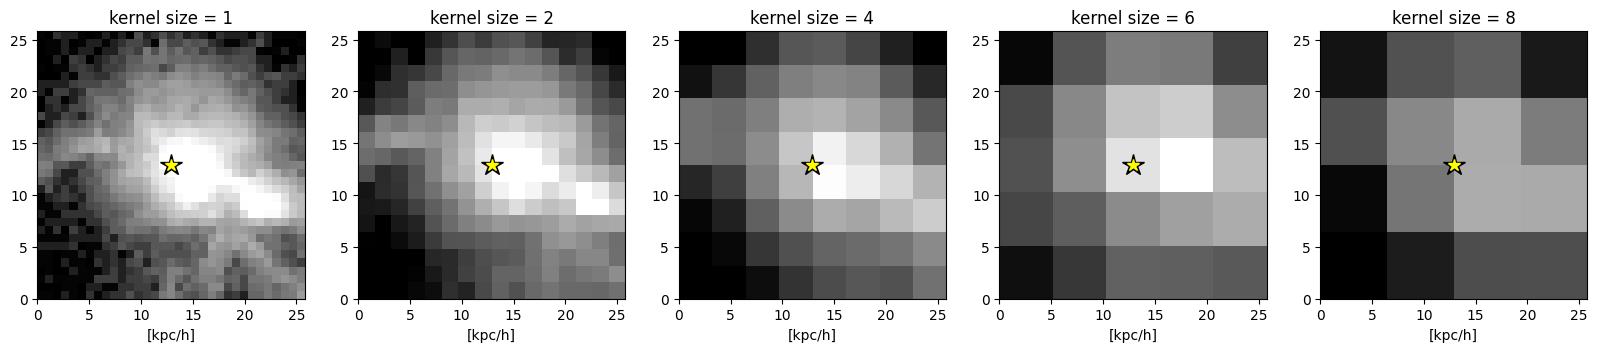

# Here we choose kernel size of 4.
# Reshaping the arrays to prepare for CNN training


In [5]:
print('# CNN takes a smoothing kernel size as an input for training.')
print('# We want to pick a reasonable smoothing kernel size to save computation time while retaining all the relevant features.')
fig, axes = plt.subplots(1,5,figsize=(20,4))
for iax, kSize in enumerate([1,2,4,6,8]):
    imax, ndim2 = (ndim//kSize)*kSize, ndim//kSize
    Xsample = X_train[0,:imax,:imax,:imax].reshape(ndim2,kSize,ndim2,kSize,ndim2,kSize)
    Xsample = np.sum(Xsample,axis=(1,3,5))/kSize**3
    
    plotLocDenSlice(Xsample[:,:,ndim2//2], axes[iax], fig, False, f'kernel size = {kSize}')
    # plt.imshow(Xsample[:,:,ndim2//2].T,origin='lower',)
    # plt.title("Kernel size: "+str(Lk))
plt.show()
kSize = 4
print(f'# Here we choose kernel size of {kSize}.')
print('# Reshaping the arrays to prepare for CNN training')
X_train  = X_train.reshape(N_train,ndim,ndim,ndim,1)
X_val    = X_val.reshape(N_val,ndim,ndim,ndim,1)
X_test   = X_test.reshape(N_test,ndim,ndim,ndim,1)
X2_train = X2_train.reshape(N_train,1)
X2_val   = X2_val.reshape(N_val,1)
X2_test  = X2_test.reshape(N_test,1)

In [6]:
# Model architecture 

### Hyperparameters ###
# number of layers
# type of layers
# filters (number of filters)
# kernel size
# strides
# use bias
# activation function (ReLU)
# Dropout layer/rate
# Pooling Layers
# More (neurons in) dense layers
#optimizer
#loss

from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv3D, Dense, Flatten, concatenate, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import regularizers, metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

### Define the Model ###
inputs = Input(shape=(ndim,ndim,ndim,1))
inputs2 = Input(shape=(1,1))

CNN = inputs
CNN = Conv3D(filters=8, kernel_size=kSize, padding='same',strides = 4,
             use_bias=True, data_format='channels_last',name='layer_conv2')(CNN)
CNN = BatchNormalization()(CNN)
CNN = ReLU()(CNN)
CNN = Flatten()(CNN)


#Multi-Layer Perceptron for initial density data
MLP = inputs2
MLP = Dense(16,activation='relu')(MLP)#16
MLP = Dense(8,activation='relu')(MLP)#8
MLP = Flatten()(MLP)

combinedInput = concatenate([CNN, MLP])

net = Dense(32)(combinedInput)
net = BatchNormalization()(net)
net = ReLU()(net)
net = Dropout(rate=0.1)(net)

net = Dense(1, activation='linear')(net)

outputs = net


### Compile the Model ###
#model = Model(input=[a, b], output=c)
model = Model(inputs=[inputs,inputs2], outputs=outputs)
sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
MyAdam = Adam(learning_rate=0.002)
model.compile(optimizer=MyAdam,#sgd,#MyAdam,#'adam',#'sgd'
               loss='mean_squared_error',#mean_squared_error
               metrics=['accuracy','mse','mae'])

#Plot and illustrate the model
plot_model(model, to_file='model.png', show_shapes=True); model.summary()

2025-03-31 21:19:49.691235: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 33, 33, 33,  0           []                               
                                 1)]                                                              
                                                                                                  
 layer_conv2 (Conv3D)           (None, 9, 9, 9, 8)   520         ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 1)]       0           []                               
                                            

In [9]:
# The main part that does the training. 
import time

start = time.time()

history = model.fit([X_train,X2_train], y_train,validation_data=([X_val,X2_val], y_val), batch_size=100, epochs=100)
#history = model1.fit(X_train, y_train,validation_data=(X_val, y_val), batch_size=128, epochs=3)
#You need to re-compile your functional model after you have changed parameters in .fit().
#Otherwise you continue training and "epochs" and "duration" are not reliable.

duration = (time.time() - start)/60
print("Duration:",duration,"min")

Epoch 1/100
508/508 [==============================] - 11s 19ms/step - loss: 0.1600 - accuracy: 0.0000e+00 - mse: 0.1600 - mae: 0.2746 - val_loss: 0.0248 - val_accuracy: 0.0000e+00 - val_mse: 0.0248 - val_mae: 0.1205
Epoch 2/100
508/508 [==============================] - 10s 20ms/step - loss: 0.0405 - accuracy: 0.0000e+00 - mse: 0.0405 - mae: 0.1564 - val_loss: 0.0245 - val_accuracy: 0.0000e+00 - val_mse: 0.0245 - val_mae: 0.1200
Epoch 3/100
508/508 [==============================] - 10s 20ms/step - loss: 0.0329 - accuracy: 0.0000e+00 - mse: 0.0329 - mae: 0.1408 - val_loss: 0.0201 - val_accuracy: 0.0000e+00 - val_mse: 0.0201 - val_mae: 0.1068
Epoch 4/100
508/508 [==============================] - 11s 22ms/step - loss: 0.0295 - accuracy: 0.0000e+00 - mse: 0.0295 - mae: 0.1331 - val_loss: 0.0194 - val_accuracy: 0.0000e+00 - val_mse: 0.0194 - val_mae: 0.1025
Epoch 5/100
508/508 [==============================] - 12s 24ms/step - loss: 0.0282 - accuracy: 0.0000e+00 - mse: 0.0282 - mae: 0.13

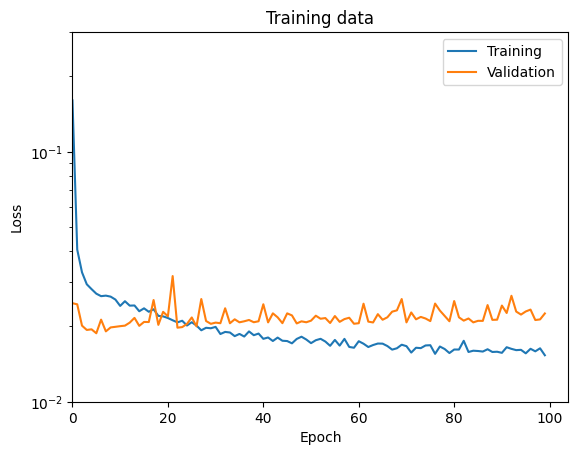

199/199 [==============================] - 1s 7ms/step - loss: 0.0225 - accuracy: 0.0000e+00 - mse: 0.0225 - mae: 0.1130
Show Metrics:
loss 0.022527439519762993
accuracy 0.0
mse 0.022527439519762993
mae 0.11299986392259598


In [20]:
# model.save('model.keras')

plt.plot(history.history['loss'],label="Training")
plt.plot(history.history['val_loss'],label="Validation")
plt.ylabel('Loss'); plt.yscale("log"); plt.ylim(1e-2,3e-1)
plt.xlabel('Epoch'); plt.xlim(0)
plt.title('Training data'); plt.legend()
plt.show()

result = model.evaluate(x=[X_val,X2_val],y=y_val)
print("Show Metrics:")
for name, value in zip(model.metrics_names, result):
    print(name, value)

# Final results

199/199 [==============================] - 1s 7ms/step


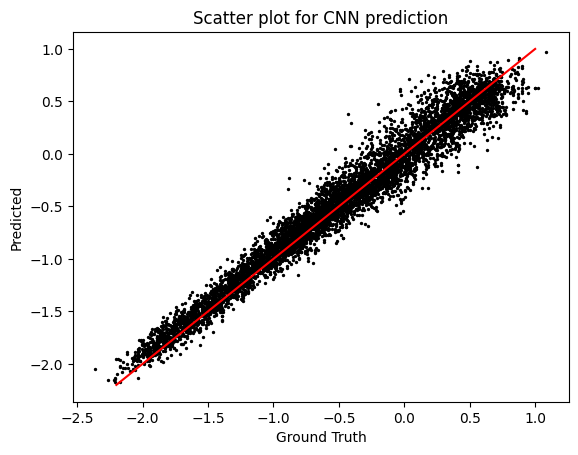

In [26]:
pred=model.predict(x=[X_test,X2_test])
#Re-normalize back to physical quantities
#y_val_ReNorm = np.zeros(y_val.shape)
# pred            = pred    * y_std + y_mean
# y_test_ReNorm   = y_test  * y_std + y_mean 
plt.scatter(y_test,pred,s=2,color='k')
plt.plot([-2.2,1],[-2.2,1],c="r")
plt.ylabel("Predicted")
plt.xlabel("Ground Truth")
plt.title("Scatter plot for CNN prediction")
plt.show()